# Baselines
> This notebook is used to run the baselines for the GCN-ID 2024 dataset.

In [1]:
#| default_exp baselines

In [2]:
#| eval: false
import os
import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wildlife_tools.similarity import CosineSimilarity
from wildlife_datasets import analysis, datasets, splits
import pycocotools.mask as mask_util
from wildlife_tools.data import ImageDataset
from sklearn.metrics import average_precision_score
import numpy as np
import timm
from transformers import AutoModel
import torch
import numpy as np
from wildlife_tools.inference import TopkClassifier, KnnClassifier
from wildlife_tools.features import DeepFeatures
import torchvision.transforms as T
from PIL import Image
import kaggle
import pandas as pd
from wildlife_tools.data import ImageDataset, FeatureDataset, FeatureDatabase
from gcn_reid.segmentation import decode_rle_mask
from gcn_reid.newt_dataset import upload_to_kaggle
from pathlib import Path
from gcn_reid.newt_dataset import download_kaggle_dataset
from tqdm import tqdm
from transformers import AutoImageProcessor, AutoModel
import cv2

2025-06-26 16:41:47.199241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750956107.222767   89844 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750956107.229954   89844 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
dataset_name = 'mshahoyi/gcn-id-2024'
dataset_path = Path('data/gcn-id-2024')
download_kaggle_dataset(dataset_name, dataset_path)

Dataset already exists at data/gcn-id-2024


PosixPath('data/gcn-id-2024')

In [4]:
#| output: false
mega = timm.create_model('hf-hub:BVRA/MegaDescriptor-L-384', pretrained=True, num_classes=0)
miewid = AutoModel.from_pretrained("conservationxlabs/miewid-msv2", trust_remote_code=True)

Building Model Backbone for efficientnetv2_rw_m model
config.model_name efficientnetv2_rw_m
model_name efficientnetv2_rw_m
final_in_features 2152


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for conv_stem.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to

## Run both models on all test sets and save the results
Artifacts are a dataframe like the newt dataframe but that contains two new columns representing the mega and miewid embeddings.

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mega_extractor = DeepFeatures(mega, device=device, batch_size=32, num_workers=4)
miewid_extractor = DeepFeatures(miewid, device=device, batch_size=32, num_workers=4)

In [6]:
df = pd.read_csv(dataset_path / 'metadata.csv')
mask = df.is_hard_test_query.notna() | df.is_least_similar_test_query.notna() | df.is_random_test_query.notna()
df = df[mask & ~df.is_video].reset_index(drop=True).rename(columns={"file_name": "image_name", "file_path": "path"})
df

,reference_id,path,image_name,is_video,identity,creation_date,bbox,segmentation_mask_rle,is_hard_test_query,is_hard_val_query,is_least_similar_test_query,is_least_similar_val_query,is_random_test_query,is_random_val_query
0,GCN34-P3-S2,newts/1/IMG_2532.JPEG,IMG_2532.JPEG,False,1,2024-05-10 08:37:21+00:00,"[14.939163208007812, 507.19061279296875, 1066....",2048x1536:Sd`03ko14N0000000bNKcRN0^O5om1KcRN1]...,NaN,False,NaN,NaN,True,NaN
1,GCN34-P3-S2,newts/1/IMG_2530.JPEG,IMG_2530.JPEG,False,1,2024-05-10 08:37:19+00:00,"[288.80975341796875, 363.1075439453125, 1062.7...",2048x1536:[ajb03;31K_n1:YQN10O4Knm1h0lQN_O2O0M...,NaN,False,NaN,NaN,False,NaN
2,GCN34-P3-S2,newts/1/IMG_2531.JPEG,IMG_2531.JPEG,False,1,2024-05-10 08:37:20+00:00,"[288.86181640625, 521.5284423828125, 1159.4096...",2048x1536:Pcdb07^o1d0D7H=E5K5L5J5K3M4M3M10001N...,NaN,False,NaN,NaN,False,NaN
3,GCN34-P3-S2,newts/1/IMG_2533.JPEG,IMG_2533.JPEG,False,1,2024-05-10 08:37:23+00:00,"[489.2838134765625, 169.9361572265625, 1132.72...",2048x1536:X`Vo06do1;H;dNH]RN>[m1e1]O5M4K4M3M3L...,NaN,False,NaN,NaN,False,NaN
4,GCN34-P3-S2,newts/1/IMG_2534.JPEG,IMG_2534.JPEG,False,1,2024-05-10 08:37:24+00:00,"[365.6585388183594, 454.51068115234375, 1005.9...",2048x1536:SmZd03lo13M3M2O1O1N2`QNJTm16gRN3Vm1M...,NaN,True,NaN,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,GCN7-P3-S6,newts/202/IMG_3618.JPEG,IMG_3618.JPEG,False,202,2024-06-07 08:17:00+00:00,"[173.46243286132812, 251.09988403320312, 1007....",2046x1538:]UV;2m18ek14RSNJ_O159;@8:j0KRe10^YN2...,False,NaN,False,NaN,NaN,NaN
419,GCN7-P3-S6,newts/202/IMG_3617.JPEG,IMG_3617.JPEG,False,202,2024-06-07 08:16:56+00:00,"[333.4060974121094, 442.3371887207031, 1123.58...",2046x1538:Rlde0g0km1G_RNDOQ1ol1POoRN\2kl1`0J5T...,False,NaN,False,NaN,NaN,NaN
420,GCN7-P3-S6,newts/202/IMG_3616.JPEG,IMG_3616.JPEG,False,202,2024-06-07 08:16:55+00:00,"[372.7743225097656, 699.0594482421875, 1003.42...",2046x1538:k_lg0;4Kan1c1SO`0D;G8J7H7L4K5L4M4L3M...,True,NaN,False,NaN,NaN,NaN
421,GCN7-P3-S6,newts/202/IMG_3615.JPEG,IMG_3615.JPEG,False,202,2024-06-07 08:16:54+00:00,"[414.04083251953125, 1346.5162353515625, 966.7...",2046x1538:Ph`j0<So1h0B?[Oc0Al0WO8I9Bc0C<C6K6I6...,False,NaN,True,NaN,NaN,NaN


In [7]:
mega_transform = T.Compose([T.Resize(384),
                            T.CenterCrop(384),
                            T.ToTensor(), 
                            T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]) 

miewid_transform = T.Compose([
    T.Resize(400),
    T.CenterCrop(400),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mega_transform_rotated = T.Compose([T.Resize(384),
                            T.CenterCrop(384),
                            T.RandomRotation([90, 90]),  # Add 90 degree clockwise rotation
                            T.ToTensor(), 
                            T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]) 

miewid_transform_rotated = T.Compose([
    T.Resize(400),
    T.CenterCrop(400),
    T.RandomRotation([90, 90]),  # Add 90 degree clockwise rotation
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
#| export
def get_cropped_newt(path, rle):
    import cv2
    from gcn_reid.segmentation import decode_rle_mask
    from PIL import Image
    import numpy as np

    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = decode_rle_mask(rle)
    if mask is None: return Image.fromarray(img)
    
    img_array = np.array(img)
    masked_img = img_array * mask[:, :, np.newaxis]
    return Image.fromarray(masked_img)

In [9]:
#| export
def get_cropping_image_dataset():
    import cv2
    from PIL import Image
    from wildlife_tools.data import ImageDataset

    class CroppingImageDataset(ImageDataset):
        """Dataset that crops an image using an RLE segmentation mask."""
        
        def __init__(self, *image_dataset_args, crop_out=True, rle_col="segmentation_mask_rle", **image_dataset_kwargs):
            super().__init__(*image_dataset_args, **image_dataset_kwargs)
            self.crop_out = crop_out
            self.rle_col = rle_col

        def get_image(self, path):
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            if not self.crop_out: return Image.fromarray(img)
            
            relative_path = path.replace(str(self.root), "")[1:] # remove leading /
            rle = self.metadata[self.metadata[self.col_path] == relative_path][self.rle_col].values
            if len(rle) == 0: return Image.fromarray(img)
            return get_cropped_newt(path, rle[0])

    return CroppingImageDataset

In [10]:
CroppingImageDataset = get_cropping_image_dataset()

mega_cropping_dataset = CroppingImageDataset(df, root=dataset_path, transform=mega_transform, crop_out=True)
miewid_cropping_dataset = CroppingImageDataset(df, root=dataset_path, transform=miewid_transform, crop_out=True)
mega_cropping_dataset_rotated = CroppingImageDataset(df, root=dataset_path, transform=mega_transform_rotated, crop_out=True)
miewid_cropping_dataset_rotated = CroppingImageDataset(df, root=dataset_path, transform=miewid_transform_rotated, crop_out=True)

mega_dataset = ImageDataset(df, root=dataset_path, transform=mega_transform)
miewid_dataset = ImageDataset(df, root=dataset_path, transform=miewid_transform)
mega_dataset_rotated = ImageDataset(df, root=dataset_path, transform=mega_transform_rotated)
miewid_dataset_rotated = ImageDataset(df, root=dataset_path, transform=miewid_transform_rotated)

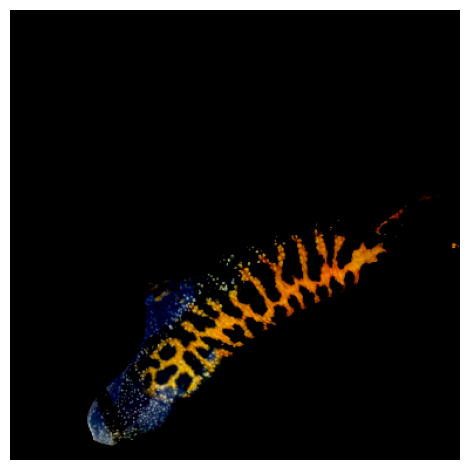

In [11]:
num_images = 1
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    x, y = next(iter(mega_cropping_dataset_rotated))
    plt.imshow(x.permute(1, 2, 0))
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('mega_images.png')

In [12]:
artifacts_path = Path('artifacts')
artifacts_path.mkdir(exist_ok=True)
artifacts_name = 'baseline_features.csv'

In [13]:
if not (artifacts_path/artifacts_name).exists():
    mega_results = mega_extractor(mega_dataset)
    miewid_results = miewid_extractor(miewid_dataset)
    mega_results_cropped = mega_extractor(mega_cropping_dataset)
    miewid_results_cropped = miewid_extractor(miewid_cropping_dataset)
    mega_results_cropped_rotated = mega_extractor(mega_cropping_dataset_rotated)
    miewid_results_cropped_rotated = miewid_extractor(miewid_cropping_dataset_rotated)
    mega_results_rotated = mega_extractor(mega_dataset_rotated)
    miewid_results_rotated = miewid_extractor(miewid_dataset_rotated)

    df['mega_features'] = [features.tolist() for features in mega_results.features]
    df['miewid_features'] = [features.tolist() for features in miewid_results.features]
    df['mega_features_cropped'] = [features.tolist() for features in mega_results_cropped.features]
    df['miewid_features_cropped'] = [features.tolist() for features in miewid_results_cropped.features]
    df['mega_features_cropped_rotated'] = [features.tolist() for features in mega_results_cropped_rotated.features]
    df['miewid_features_cropped_rotated'] = [features.tolist() for features in miewid_results_cropped_rotated.features]
    df['mega_features_rotated'] = [features.tolist() for features in mega_results_rotated.features]
    df['miewid_features_rotated'] = [features.tolist() for features in miewid_results_rotated.features]
    df.to_csv(artifacts_path/artifacts_name, index=False)
else: 
    df = pd.read_csv(artifacts_path/artifacts_name)
    df['mega_features'] = df['mega_features'].apply(eval)
    df['miewid_features'] = df['miewid_features'].apply(eval)
    df['mega_features_cropped'] = df['mega_features_cropped'].apply(eval)
    df['miewid_features_cropped'] = df['miewid_features_cropped'].apply(eval)
    df['mega_features_cropped_rotated'] = df['mega_features_cropped_rotated'].apply(eval)
    df['miewid_features_cropped_rotated'] = df['miewid_features_cropped_rotated'].apply(eval)
    df['mega_features_rotated'] = df['mega_features_rotated'].apply(eval)
    df['miewid_features_rotated'] = df['miewid_features_rotated'].apply(eval)

In [ ]:
similarity_function = CosineSimilarity()

def get_top_k_accuracy(df, query_col, feature_col, k=1, database_feature_col=None):
    query_df = df[df[query_col] == True].reset_index(drop=True)
    database_df = df[df[query_col] != True].reset_index(drop=True)

    query_dataset = FeatureDataset(features=query_df[feature_col].tolist(), metadata=query_df)
    database_dataset = FeatureDataset(features=database_df[database_feature_col if database_feature_col else feature_col].tolist(), metadata=database_df)

    similarity = similarity_function(query_dataset, database_dataset)

    classifier = TopkClassifier(k=k, database_labels=database_dataset.labels_string, return_all=True)
    predictions, scores, idx = classifier(similarity)
    y = query_dataset.labels_string[:, np.newaxis]
    accuracy = np.mean(np.any(y == predictions, axis=1))

    query_identities = query_dataset.labels_string
    query_filenames = query_df['image_name'].values

    preds_df = pd.DataFrame(predictions, columns=pd.MultiIndex.from_product([['predicted_identity'], range(1, k+1)]))
    scores_df = pd.DataFrame(scores, columns=pd.MultiIndex.from_product([['score'], range(1, k+1)]))
    filenames_df = pd.DataFrame(database_df.iloc[idx.flatten()]['image_name'].values.reshape(idx.shape), columns=pd.MultiIndex.from_product([['predicted_image_name'], range(1, k+1)]))
    query_df = pd.DataFrame(np.column_stack([query_identities, query_filenames]), columns=pd.MultiIndex.from_product([['query'], ['identity', 'image_name']]))
    top_k_df = pd.concat([query_df, preds_df, scores_df, filenames_df], axis=1)

    return accuracy, top_k_df

accuracy, top_k_df = get_top_k_accuracy(df, 'is_hard_test_query', 'miewid_features', k=5)
top_k_df

query                predicted_identity                         score  \
   identity     image_name                  1    2    3    4    5         1   
0         4  IMG_2545.JPEG                  4    9    5   31   28  0.724900   
1        28  IMG_2488.JPEG                 28   30    8   54   27  0.732097   
2        31  IMG_2521.JPEG                 31   25   41   71    9  0.832421   
3        39  IMG_2321.JPEG                 28   39   57  181    4  0.534586   
4        41  IMG_2391.JPEG                 41   28   50   37   31  0.656017   
5        44  IMG_2338.JPEG                 47   57   46   29   22  0.528066   
6        50  IMG_2411.JPEG                 50   28   84   30   16  0.677512   
7        54  IMG_2399.JPEG                 54   21   13   14   31  0.753215   
8        57  IMG_2352.JPEG                 46  119   50   57    9  0.438227   
9        59  IMG_2720.JPEG                 59   41   28  178  181  0.774729   
10       68  IMG_3809.JPEG                 68  199  197  202   12  0.378799   
11       71  IMG_3884.JPEG                 71   31   41  119  178  0.717556   
12       84  IMG_2858.JPEG                 84   47   46   28   50  0.607246   
13       85  IMG_2875.JPEG                  8   28   25   85   89  0.636757   
14       89  IMG_2836.JPEG                117   89   47  119  104  0.617693   
15       92  IMG_2801.JPEG                 92  139   13   16   54  0.699239   
16      102  IMG_3556.JPEG                102  197   12  139  199  0.853831   
17      104  IMG_3141.JPEG                104  117  119  139  191  0.661345   
18      116  IMG_3109.JPEG                116   14   31  158   10  0.668391   
19      117  IMG_3100.JPEG                 19  117    8   37   18  0.698817   
20      126  IMG_3251.JPEG                126  139  104   59  119  0.629487   
21      128  IMG_3178.JPEG                128    9  195   41   71  0.641611   
22      139  IMG_2910.JPEG                139  183  104  116  119  0.767497   
23      158  IMG_3350.JPEG                158   59   50   41   70  0.592602   
24      165  IMG_3281.JPEG                178   31  119  181   14  0.515876   
25      178  IMG_3384.JPEG                178   25    9   71   41  0.788880   
26      191  IMG_3663.JPEG                191  195   20   41   13  0.736426   
27      195  IMG_3659.JPEG                195  191  117   15   71  0.726708   
28      197  IMG_3608.JPEG                102   11  199  197   27  0.370432   
29      202  IMG_3616.JPEG                202  197  199  126   26  0.512071   

                                           predicted_image_name  \
           2         3         4         5                    1   
0   0.669199  0.664537  0.648287  0.644597        IMG_2546.JPEG   
1   0.706550  0.674637  0.660041  0.657237        IMG_2490.JPEG   
2   0.702387  0.696077  0.688054  0.666718        IMG_2519.JPEG   
3   0.528971  0.525703  0.508656  0.504368        IMG_2486.JPEG   
4   0.608335  0.595848  0.593409  0.590966        IMG_2392.JPEG   
5   0.525686  0.524369  0.515956  0.514654        IMG_2358.JPEG   
6   0.601997  0.594606  0.591716  0.577166        IMG_2410.JPEG   
7   0.690221  0.655265  0.653530  0.646022        IMG_2403.JPEG   
8   0.426473  0.423811  0.387412  0.384438        IMG_2330.JPEG   
9   0.682074  0.674501  0.672033  0.661656        IMG_2718.JPEG   
10  0.353345  0.351397  0.339890  0.330514        IMG_3805.JPEG   
11  0.677027  0.647288  0.647048  0.643674        IMG_3885.JPEG   
12  0.581266  0.546994  0.546238  0.540468        IMG_2859.JPEG   
13  0.610658  0.609270  0.603354  0.602769        IMG_2585.JPEG   
14  0.612058  0.597806  0.574640  0.564394        IMG_3099.JPEG   
15  0.619799  0.594736  0.592516  0.589169        IMG_2802.JPEG   
16  0.523109  0.447423  0.439412  0.424171        IMG_3557.JPEG   
17  0.603737  0.598735  0.597498  0.596887        IMG_3140.JPEG   
18  0.616541  0.614679  0.605539  0.595929        IMG_3106.JPEG   
19  0.682098  0.666107  0.659217  0.657740        IMG_2646.JPEG   
20 

In [15]:
def calculate_map(df, query_col, feature_col, database_feature_col=None):
    """
    Calculate mean Average Precision (mAP) for retrieval task.
    
    Args:
        df: DataFrame containing features and metadata
        query_col: Column name indicating query samples (boolean)
        feature_col: Column name containing features for queries
        database_feature_col: Column name containing features for database (if different from feature_col)
    
    Returns:
        mAP: Mean Average Precision score
    """
    from sklearn.metrics import average_precision_score
    
    query_df = df[df[query_col] == True].reset_index(drop=True)
    database_df = df[df[query_col] != True].reset_index(drop=True)

    query_dataset = FeatureDataset(features=query_df[feature_col].tolist(), metadata=query_df)
    database_dataset = FeatureDataset(features=database_df[database_feature_col if database_feature_col else feature_col].tolist(), metadata=database_df)

    similarity = similarity_function(query_dataset, database_dataset)
    
    aps = []
    
    for i, query_label in enumerate(query_dataset.labels_string):
        # Get similarity scores for this query
        scores = similarity[i]
        
        # Create binary relevance labels (1 if same identity, 0 otherwise)
        relevance = (database_dataset.labels_string == query_label).astype(int)
        
        # Calculate Average Precision for this query
        if np.sum(relevance) > 0:  # Only if there are relevant items
            ap = average_precision_score(relevance, scores)
            aps.append(ap)
    
    return np.mean(aps) if aps else 0.0

In [16]:
test_map = calculate_map(df, 'is_hard_test_query', 'miewid_features')
test_map

0.4900472748367101

In [17]:
# Calculate mAP for all your configurations
# Hard test queries
map_mega_hard = calculate_map(df, 'is_hard_test_query', 'mega_features')
map_miewid_hard = calculate_map(df, 'is_hard_test_query', 'miewid_features')
map_mega_hard_cropped = calculate_map(df, 'is_hard_test_query', 'mega_features_cropped')
map_miewid_hard_cropped = calculate_map(df, 'is_hard_test_query', 'miewid_features_cropped')
map_mega_hard_rotated = calculate_map(df, 'is_hard_test_query', 'mega_features', 'mega_features_rotated')
map_miewid_hard_rotated = calculate_map(df, 'is_hard_test_query', 'miewid_features', 'miewid_features_rotated')
map_mega_hard_cropped_rotated = calculate_map(df, 'is_hard_test_query', 'mega_features_cropped', 'mega_features_cropped_rotated')
map_miewid_hard_cropped_rotated = calculate_map(df, 'is_hard_test_query', 'miewid_features_cropped', 'miewid_features_cropped_rotated')

# Random test queries
map_mega_random = calculate_map(df, 'is_random_test_query', 'mega_features')
map_miewid_random = calculate_map(df, 'is_random_test_query', 'miewid_features')
map_mega_random_cropped = calculate_map(df, 'is_random_test_query', 'mega_features_cropped')
map_miewid_random_cropped = calculate_map(df, 'is_random_test_query', 'miewid_features_cropped')
map_mega_random_rotated = calculate_map(df, 'is_random_test_query', 'mega_features', 'mega_features_rotated')
map_miewid_random_rotated = calculate_map(df, 'is_random_test_query', 'miewid_features', 'miewid_features_rotated')
map_mega_random_cropped_rotated = calculate_map(df, 'is_random_test_query', 'mega_features_cropped', 'mega_features_cropped_rotated')
map_miewid_random_cropped_rotated = calculate_map(df, 'is_random_test_query', 'miewid_features_cropped', 'miewid_features_cropped_rotated')

# Least similar test queries
map_mega_least = calculate_map(df, 'is_least_similar_test_query', 'mega_features')
map_miewid_least = calculate_map(df, 'is_least_similar_test_query', 'miewid_features')
map_mega_least_cropped = calculate_map(df, 'is_least_similar_test_query', 'mega_features_cropped')
map_miewid_least_cropped = calculate_map(df, 'is_least_similar_test_query', 'miewid_features_cropped')
map_mega_least_rotated = calculate_map(df, 'is_least_similar_test_query', 'mega_features', 'mega_features_rotated')
map_miewid_least_rotated = calculate_map(df, 'is_least_similar_test_query', 'miewid_features', 'miewid_features_rotated')
map_mega_least_cropped_rotated = calculate_map(df, 'is_least_similar_test_query', 'mega_features_cropped', 'mega_features_cropped_rotated')
map_miewid_least_cropped_rotated = calculate_map(df, 'is_least_similar_test_query', 'miewid_features_cropped', 'miewid_features_cropped_rotated')

In [18]:
acc_mega_top_1_hard, acc_mega_top_1_hard_df = get_top_k_accuracy(df, 'is_hard_test_query', 'mega_features', k=1)
acc_mega_top_5_hard, acc_mega_top_5_hard_df = get_top_k_accuracy(df, 'is_hard_test_query', 'mega_features', k=5)
acc_miewid_top_1_hard, acc_miewid_top_1_hard_df = get_top_k_accuracy(df, 'is_hard_test_query', 'miewid_features', k=1)
acc_miewid_top_5_hard, acc_miewid_top_5_hard_df = get_top_k_accuracy(df, 'is_hard_test_query', 'miewid_features', k=5)

In [19]:
acc_mega_top_1_hard_cropped, acc_mega_top_1_hard_cropped_df = get_top_k_accuracy(df, 'is_hard_test_query', 'mega_features_cropped', k=1)
acc_mega_top_5_hard_cropped, acc_mega_top_5_hard_cropped_df = get_top_k_accuracy(df, 'is_hard_test_query', 'mega_features_cropped', k=5)
acc_miewid_top_1_hard_cropped, acc_miewid_top_1_hard_cropped_df = get_top_k_accuracy(df, 'is_hard_test_query', 'miewid_features_cropped', k=1)
acc_miewid_top_5_hard_cropped, acc_miewid_top_5_hard_cropped_df = get_top_k_accuracy(df, 'is_hard_test_query', 'miewid_features_cropped', k=5)

In [20]:
acc_mega_top_1_hard_rotated, acc_mega_top_1_hard_rotated_df = get_top_k_accuracy(df, 'is_hard_test_query', 'mega_features', k=1, database_feature_col='mega_features_rotated')
acc_mega_top_5_hard_rotated, acc_mega_top_5_hard_rotated_df = get_top_k_accuracy(df, 'is_hard_test_query', 'mega_features', k=5, database_feature_col='mega_features_rotated')
acc_miewid_top_1_hard_rotated, acc_miewid_top_1_hard_rotated_df = get_top_k_accuracy(df, 'is_hard_test_query', 'miewid_features', k=1, database_feature_col='miewid_features_rotated')
acc_miewid_top_5_hard_rotated, acc_miewid_top_5_hard_rotated_df = get_top_k_accuracy(df, 'is_hard_test_query', 'miewid_features', k=5, database_feature_col='miewid_features_rotated')

In [21]:
acc_mega_top_1_hard_cropped_rotated, acc_mega_top_1_hard_cropped_rotated_df = get_top_k_accuracy(df, 'is_hard_test_query', 'mega_features_cropped', k=1, database_feature_col='mega_features_cropped_rotated')
acc_mega_top_5_hard_cropped_rotated, acc_mega_top_5_hard_cropped_rotated_df = get_top_k_accuracy(df, 'is_hard_test_query', 'mega_features_cropped', k=5, database_feature_col='mega_features_cropped_rotated')
acc_miewid_top_1_hard_cropped_rotated, acc_miewid_top_1_hard_cropped_rotated_df = get_top_k_accuracy(df, 'is_hard_test_query', 'miewid_features_cropped', k=1, database_feature_col='miewid_features_cropped_rotated')
acc_miewid_top_5_hard_cropped_rotated, acc_miewid_top_5_hard_cropped_rotated_df = get_top_k_accuracy(df, 'is_hard_test_query', 'miewid_features_cropped', k=5, database_feature_col='miewid_features_cropped_rotated')

In [22]:
acc_mega_top_1_random, acc_mega_top_1_random_df = get_top_k_accuracy(df, 'is_random_test_query', 'mega_features', k=1)
acc_mega_top_5_random, acc_mega_top_5_random_df = get_top_k_accuracy(df, 'is_random_test_query', 'mega_features', k=5)
acc_miewid_top_1_random, acc_miewid_top_1_random_df = get_top_k_accuracy(df, 'is_random_test_query', 'miewid_features', k=1)
acc_miewid_top_5_random, acc_miewid_top_5_random_df = get_top_k_accuracy(df, 'is_random_test_query', 'miewid_features', k=5)

In [23]:
acc_mega_top_1_random_cropped, acc_mega_top_1_random_cropped_df = get_top_k_accuracy(df, 'is_random_test_query', 'mega_features_cropped', k=1)
acc_mega_top_5_random_cropped, acc_mega_top_5_random_cropped_df = get_top_k_accuracy(df, 'is_random_test_query', 'mega_features_cropped', k=5)
acc_miewid_top_1_random_cropped, acc_miewid_top_1_random_cropped_df = get_top_k_accuracy(df, 'is_random_test_query', 'miewid_features_cropped', k=1)
acc_miewid_top_5_random_cropped, acc_miewid_top_5_random_cropped_df = get_top_k_accuracy(df, 'is_random_test_query', 'miewid_features_cropped', k=5)

In [24]:
acc_mega_top_1_random_rotated, acc_mega_top_1_random_rotated_df = get_top_k_accuracy(df, 'is_random_test_query', 'mega_features', k=1, database_feature_col='mega_features_rotated')
acc_mega_top_5_random_rotated, acc_mega_top_5_random_rotated_df = get_top_k_accuracy(df, 'is_random_test_query', 'mega_features', k=5, database_feature_col='mega_features_rotated')
acc_miewid_top_1_random_rotated, acc_miewid_top_1_random_rotated_df = get_top_k_accuracy(df, 'is_random_test_query', 'miewid_features', k=1, database_feature_col='miewid_features_rotated')
acc_miewid_top_5_random_rotated, acc_miewid_top_5_random_rotated_df = get_top_k_accuracy(df, 'is_random_test_query', 'miewid_features', k=5, database_feature_col='miewid_features_rotated')

In [25]:
acc_mega_top_1_random_cropped_rotated, acc_mega_top_1_random_cropped_rotated_df = get_top_k_accuracy(df, 'is_random_test_query', 'mega_features_cropped', k=1, database_feature_col='mega_features_cropped_rotated')
acc_mega_top_5_random_cropped_rotated, acc_mega_top_5_random_cropped_rotated_df = get_top_k_accuracy(df, 'is_random_test_query', 'mega_features_cropped', k=5, database_feature_col='mega_features_cropped_rotated')
acc_miewid_top_1_random_cropped_rotated, acc_miewid_top_1_random_cropped_rotated_df = get_top_k_accuracy(df, 'is_random_test_query', 'miewid_features_cropped', k=1, database_feature_col='miewid_features_cropped_rotated')
acc_miewid_top_5_random_cropped_rotated, acc_miewid_top_5_random_cropped_rotated_df = get_top_k_accuracy(df, 'is_random_test_query', 'miewid_features_cropped', k=5, database_feature_col='miewid_features_cropped_rotated')

In [26]:
acc_mega_top_1_least, acc_mega_top_1_least_df = get_top_k_accuracy(df, 'is_least_similar_test_query', 'mega_features', k=1)
acc_mega_top_5_least, acc_mega_top_5_least_df = get_top_k_accuracy(df, 'is_least_similar_test_query', 'mega_features', k=5)
acc_miewid_top_1_least, acc_miewid_top_1_least_df = get_top_k_accuracy(df, 'is_least_similar_test_query', 'miewid_features', k=1)
acc_miewid_top_5_least, acc_miewid_top_5_least_df = get_top_k_accuracy(df, 'is_least_similar_test_query', 'miewid_features', k=5)

In [27]:
acc_mega_top_1_least_cropped, acc_mega_top_1_least_cropped_df = get_top_k_accuracy(df, 'is_least_similar_test_query', 'mega_features_cropped', k=1)
acc_mega_top_5_least_cropped, acc_mega_top_5_least_cropped_df = get_top_k_accuracy(df, 'is_least_similar_test_query', 'mega_features_cropped', k=5)
acc_miewid_top_1_least_cropped, acc_miewid_top_1_least_cropped_df = get_top_k_accuracy(df, 'is_least_similar_test_query', 'miewid_features_cropped', k=1)
acc_miewid_top_5_least_cropped, acc_miewid_top_5_least_cropped_df = get_top_k_accuracy(df, 'is_least_similar_test_query', 'miewid_features_cropped', k=5)

In [28]:
acc_mega_top_1_least_rotated, acc_mega_top_1_least_rotated_df = get_top_k_accuracy(df, 'is_least_similar_test_query', 'mega_features', k=1, database_feature_col='mega_features_rotated')
acc_mega_top_5_least_rotated, acc_mega_top_5_least_rotated_df = get_top_k_accuracy(df, 'is_least_similar_test_query', 'mega_features', k=5, database_feature_col='mega_features_rotated')
acc_miewid_top_1_least_rotated, acc_miewid_top_1_least_rotated_df = get_top_k_accuracy(df, 'is_least_similar_test_query', 'miewid_features', k=1, database_feature_col='miewid_features_rotated')
acc_miewid_top_5_least_rotated, acc_miewid_top_5_least_rotated_df = get_top_k_accuracy(df, 'is_least_similar_test_query', 'miewid_features', k=5, database_feature_col='miewid_features_rotated')

In [29]:
acc_mega_top_1_least_cropped_rotated, acc_mega_top_1_least_cropped_rotated_df = get_top_k_accuracy(df, 'is_least_similar_test_query', 'mega_features_cropped', k=1, database_feature_col='mega_features_cropped_rotated')
acc_mega_top_5_least_cropped_rotated, acc_mega_top_5_least_cropped_rotated_df = get_top_k_accuracy(df, 'is_least_similar_test_query', 'mega_features_cropped', k=5, database_feature_col='mega_features_cropped_rotated')
acc_miewid_top_1_least_cropped_rotated, acc_miewid_top_1_least_cropped_rotated_df = get_top_k_accuracy(df, 'is_least_similar_test_query', 'miewid_features_cropped', k=1, database_feature_col='miewid_features_cropped_rotated')
acc_miewid_top_5_least_cropped_rotated, acc_miewid_top_5_least_cropped_rotated_df = get_top_k_accuracy(df, 'is_least_similar_test_query', 'miewid_features_cropped', k=5, database_feature_col='miewid_features_cropped_rotated')

In [30]:
# Splits
random = 'Random'
least_similar = 'Least Similar'
hard = 'Hard'

# Debiasing
original = 'Original'
bg_removed = 'Background Removed'
rotated = 'Rotated'
bg_removed_rotated = 'Background Removed + Rotated'

# Models
mega = 'MegaDescriptor'
miewid = 'MiewID'

# Metrics
top_1 = 'Top-1'
top_5 = 'Top-5'
mAP = 'mAP'

# Create hierarchical index for rows
row_idx = pd.MultiIndex.from_product([
    [random, least_similar, hard],
    [original, bg_removed, rotated, bg_removed_rotated]
], names=['split', 'debiasing'])

# Create hierarchical columns
col_idx = pd.MultiIndex.from_product([
    [mega, miewid], 
    [top_1, top_5, mAP]
], names=['model', 'metric'])

# Update your results DataFrame to include mAP
# Add mAP column to your existing results_df
data_with_map = [
    # Random split
    [acc_mega_top_1_random, acc_mega_top_5_random, map_mega_random, acc_miewid_top_1_random, acc_miewid_top_5_random, map_miewid_random],
    [acc_mega_top_1_random_cropped, acc_mega_top_5_random_cropped, map_mega_random_cropped, acc_miewid_top_1_random_cropped, acc_miewid_top_5_random_cropped, map_miewid_random_cropped],
    [acc_mega_top_1_random_rotated, acc_mega_top_5_random_rotated, map_mega_random_rotated, acc_miewid_top_1_random_rotated, acc_miewid_top_5_random_rotated, map_miewid_random_rotated],
    [acc_mega_top_1_random_cropped_rotated, acc_mega_top_5_random_cropped_rotated, map_mega_random_cropped_rotated, acc_miewid_top_1_random_cropped_rotated, acc_miewid_top_5_random_cropped_rotated, map_miewid_random_cropped_rotated],
    
    # Least similar split
    [acc_mega_top_1_least, acc_mega_top_5_least, map_mega_least, acc_miewid_top_1_least, acc_miewid_top_5_least, map_miewid_least],
    [acc_mega_top_1_least_cropped, acc_mega_top_5_least_cropped, map_mega_least_cropped, acc_miewid_top_1_least_cropped, acc_miewid_top_5_least_cropped, map_miewid_least_cropped],
    [acc_mega_top_1_least_rotated, acc_mega_top_5_least_rotated, map_mega_least_rotated, acc_miewid_top_1_least_rotated, acc_miewid_top_5_least_rotated, map_miewid_least_rotated],
    [acc_mega_top_1_least_cropped_rotated, acc_mega_top_5_least_cropped_rotated, map_mega_least_cropped_rotated, acc_miewid_top_1_least_cropped_rotated, acc_miewid_top_5_least_cropped_rotated, map_miewid_least_cropped_rotated],
    
    # Hard split
    [acc_mega_top_1_hard, acc_mega_top_5_hard, map_mega_hard, acc_miewid_top_1_hard, acc_miewid_top_5_hard, map_miewid_hard],
    [acc_mega_top_1_hard_cropped, acc_mega_top_5_hard_cropped, map_mega_hard_cropped, acc_miewid_top_1_hard_cropped, acc_miewid_top_5_hard_cropped, map_miewid_hard_cropped],
    [acc_mega_top_1_hard_rotated, acc_mega_top_5_hard_rotated, map_mega_hard_rotated, acc_miewid_top_1_hard_rotated, acc_miewid_top_5_hard_rotated, map_miewid_hard_rotated],
    [acc_mega_top_1_hard_cropped_rotated, acc_mega_top_5_hard_cropped_rotated, map_mega_hard_cropped_rotated, acc_miewid_top_1_hard_cropped_rotated, acc_miewid_top_5_hard_cropped_rotated, map_miewid_hard_cropped_rotated]
]

# Create hierarchical columns including mAP
col_idx_with_map = pd.MultiIndex.from_product([
    [mega, miewid], 
    [top_1, top_5, 'mAP']
], names=['model', 'metric'])

results_df_with_map = pd.DataFrame(data_with_map, index=row_idx, columns=col_idx_with_map)
results_df_with_map.to_csv(artifacts_path/'baseline_results.csv', index=False)
results_df_with_map

model                                      MegaDescriptor                      \
metric                                              Top-1     Top-5       mAP   
split         debiasing                                                         
Random        Original                           0.933333  1.000000  0.770641   
              Background Removed                 0.800000  0.933333  0.658465   
              Rotated                            0.166667  0.733333  0.224212   
              Background Removed + Rotated       0.233333  0.566667  0.211374   
Least Similar Original                           0.566667  0.900000  0.497808   
              Background Removed                 0.366667  0.600000  0.289787   
              Rotated                            0.133333  0.600000  0.217086   
              Background Removed + Rotated       0.166667  0.400000  0.122747   
Hard          Original                           0.633333  0.833333  0.459626   
              Background Removed                 0.466667  0.600000  0.303956   
              Rotated                            0.166667  0.566667  0.181456   
              Background Removed + Rotated       0.066667  0.333333  0.113587   

model                                         MiewID                      
metric                                         Top-1     Top-5       mAP  
split         debiasing                                                   
Random        Original                      0.933333  0.966667  0.849536  
              Background Removed            0.866667  0.966667  0.720268  
              Rotated                       0.033333  0.366667  0.095128  
              Background Removed + Rotated  0.066667  0.233333  0.094184  
Least Similar Original                      0.766667  0.900000  0.570848  
              Background Removed            0.366667  0.600000  0.196391  
              Rotated                       0.133333  0.366667  0.133758  
              Background Removed + Rotated  0.033333  0.200000  0.063122  
Hard          Original                      0.733333  0.933333  0.490047  
              Background Removed            0.466667  0.666667  0.279974  
              Rotated                       0.033333  0.266667  0.075120  
              Background Removed + Rotated  0.000000  0.066667  0.041813

In [31]:
# Save results as LaTeX table
latex_table = results_df_with_map.to_latex(
    float_format=lambda x: '{:.1f}\%'.format(x*100), # Convert to percentages with 1 decimal
    bold_rows=True,
    multicolumn=True,
    multicolumn_format='c',
    multirow=True
)

with open(artifacts_path/'baseline_results.tex', 'w') as f:
    f.write(latex_table)

In [32]:
all_results_df = pd.concat([
    acc_mega_top_5_hard_df.assign(split=hard, model=mega, debiasing=original),
    acc_mega_top_5_least_df.assign(split=least_similar, model=mega, debiasing=original), 
    acc_mega_top_5_random_df.assign(split=random, model=mega, debiasing=original),
    acc_miewid_top_5_hard_df.assign(split=hard, model=miewid, debiasing=original),
    acc_miewid_top_5_least_df.assign(split=least_similar, model=miewid, debiasing=original),
    acc_miewid_top_5_random_df.assign(split=random, model=miewid, debiasing=original),
    acc_mega_top_5_hard_cropped_df.assign(split=hard, model=mega, debiasing=bg_removed),
    acc_mega_top_5_least_cropped_df.assign(split=least_similar, model=mega, debiasing=bg_removed), 
    acc_mega_top_5_random_cropped_df.assign(split=random, model=mega, debiasing=bg_removed),
    acc_miewid_top_5_hard_cropped_df.assign(split=hard, model=miewid, debiasing=bg_removed),
    acc_miewid_top_5_least_cropped_df.assign(split=least_similar, model=miewid, debiasing=bg_removed), 
    acc_miewid_top_5_random_cropped_df.assign(split=random, model=miewid, debiasing=bg_removed),
    acc_mega_top_5_hard_rotated_df.assign(split=hard, model=mega, debiasing=rotated),
    acc_mega_top_5_least_rotated_df.assign(split=least_similar, model=mega, debiasing=rotated),
    acc_mega_top_5_random_rotated_df.assign(split=random, model=mega, debiasing=rotated),
    acc_miewid_top_5_hard_rotated_df.assign(split=hard, model=miewid, debiasing=rotated),
    acc_miewid_top_5_least_rotated_df.assign(split=least_similar, model=miewid, debiasing=rotated),
    acc_miewid_top_5_random_rotated_df.assign(split=random, model=miewid, debiasing=rotated),
    acc_mega_top_5_hard_cropped_rotated_df.assign(split=hard, model=mega, debiasing=bg_removed_rotated),
    acc_mega_top_5_least_cropped_rotated_df.assign(split=least_similar, model=mega, debiasing=bg_removed_rotated),
    acc_mega_top_5_random_cropped_rotated_df.assign(split=random, model=mega, debiasing=bg_removed_rotated),
    acc_miewid_top_5_hard_cropped_rotated_df.assign(split=hard, model=miewid, debiasing=bg_removed_rotated),
    acc_miewid_top_5_least_cropped_rotated_df.assign(split=least_similar, model=miewid, debiasing=bg_removed_rotated),
    acc_miewid_top_5_random_cropped_rotated_df.assign(split=random, model=miewid, debiasing=bg_removed_rotated),
])

all_results_df.to_csv(artifacts_path/'baseline_predictions.csv', index=False)
all_results_df

query                predicted_identity                        score  \
   identity     image_name                  1    2    3   4    5         1   
0         4  IMG_2545.JPEG                  1   37    4  23   13  0.630716   
1        28  IMG_2488.JPEG                  8    1   41  25   28  0.643836   
2        31  IMG_2521.JPEG                 31   37  183  25   14  0.728715   
3        39  IMG_2321.JPEG                 39    6   27  21   15  0.664895   
4        41  IMG_2391.JPEG                 28   46   50  41   47  0.646801   
..      ...            ...                ...  ...  ...  ..  ...       ...   
25       26  IMG_2692.JPEG                 12   94   26  17  102  0.579380   
26       27  IMG_2450.JPEG                 27   12   15  84   17  0.576737   
27       28  IMG_2491.JPEG                102   87   17  12  199  0.674675   
28       29  IMG_2495.JPEG                102   87   17  12  199  0.570392   
29       30  IMG_2482.JPEG                 12  102   24  17   87  0.542574   

                                           predicted_image_name  \
           2         3         4         5                    1   
0   0.556669  0.555539  0.549326  0.548951        IMG_2534.JPEG   
1   0.628767  0.607394  0.596339  0.594998        IMG_2585.JPEG   
2   0.568181  0.557474  0.535568  0.528238        IMG_2518.JPEG   
3   0.523103  0.517725  0.506861  0.506137        IMG_2320.JPEG   
4   0.611557  0.573471  0.526165  0.506458        IMG_2486.JPEG   
..       ...       ...       ...       ...                  ...   
25  0.548277  0.547460  0.545223  0.545015        IMG_2677.JPEG   
26  0.565432  0.554395  0.545221  0.535901        IMG_2449.JPEG   
27  0.581423  0.570964  0.562446  0.509154        IMG_3553.JPEG   
28  0.564064  0.553170  0.515104  0.500254        IMG_3553.JPEG   
29  0.483151  0.480009  0.474428  0.474404        IMG_2677.JPEG   

                                                                 split  \
                2              3              4              5           
0   IMG_2470.JPEG  IMG_2544.JPEG  IMG_2627.JPEG  IMG_2602.JPEG    Hard   
1   IMG_2534.JPEG  IMG_2396.JPEG  IMG_2633.JPEG  IMG_2491.JPEG    Hard   
2   IMG_2471.JPEG  IMG_2290.JPEG  IMG_2630.JPEG  IMG_2612.JPEG    Hard   
3   IMG_2567.JPEG  IMG_2450.JPEG  IMG_2690.JPEG  IMG_2639.JPEG    Hard   
4   IMG_2331.JPEG  IMG_2408.JPEG  IMG_2393.JPEG  IMG_2358.JPEG    Hard   
..            ...            ...            ...            ...     ...   
25  IMG_2776.JPEG  IMG_2693.JPEG  IMG_2667.JPEG  IMG_3553.JPEG  Random   
26  IMG_2677.JPEG  IMG_2638.JPEG  IMG_2862.JPEG  IMG_2664.JPEG  Random   
27  IMG_2826.JPEG  IMG_2667.JPEG  IMG_2673.JPEG  IMG_3593.JPEG  Random   
28  IMG_2826.JPEG  IMG_2663.JPEG  IMG_2673.JPEG  IMG_3593.JPEG  Random   
29  IMG_3558.JPEG  IMG_2649.JPEG  IMG_2664.JPEG  IMG_2825.JPEG  Random   

             model                     debiasing  
                                                  
0   MegaDescriptor                      Original  
1   MegaDescriptor                      Original  
2   MegaDescriptor                      Original  
3   MegaDescriptor                      Original  
4   MegaDescriptor                      Original  
..             ...                           ...  
25          MiewID  Background Removed + Rotated  
26          MiewID  Background Removed + Rotated  
27          MiewID  Background Removed + Rotated  
28          MiewID  Background Removed + Rotated  
29          MiewID  Background Removed + Rotated  

[720 rows x 20 columns]

In [33]:
# Plot predictions from acc_mega_top_5_hard_df
def plot_predictions(query_id, query_image_name, pred_scores, pred_image_ids, pred_image_names, master_df, data_path, query_transforms, pred_transforms, denorm_mean, denorm_std, masked, model_name):
    plt.subplot(1, 6, 1)
    
    query_image_path = data_path/master_df.loc[(master_df['identity'] == int(query_id)) & (master_df['image_name'] == query_image_name)]['path'].values[0]
    
    if masked:
        rle = master_df.loc[(master_df['identity'] == int(query_id)) & (master_df['image_name'] == query_image_name)]['segmentation_mask_rle'].values[0]
        img = get_cropped_newt(query_image_path, rle)
    else:
        img = Image.open(query_image_path)

    # Un-normalize for visualization
    img_tensor = query_transforms(img)
    
    # Convert lists to tensors for proper broadcasting
    if isinstance(denorm_mean, list):
        denorm_mean = torch.tensor(denorm_mean).view(3, 1, 1)
    if isinstance(denorm_std, list):
        denorm_std = torch.tensor(denorm_std).view(3, 1, 1)
    
    img_tensor = img_tensor * denorm_std + denorm_mean
    
    plt.imshow(img_tensor.permute(1, 2, 0))
    plt.title(f'Query\nID: {query_id}', fontsize=8, bbox=dict(facecolor='lightblue', boxstyle='round', edgecolor='lightblue'))
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
    plt.xlabel(f'{query_image_name}', fontsize=6, color='gray')
    plt.ylabel(f'{model_name}', fontsize=6, color='black')
    
    # Plot predictions
    for i in range(1, 6):
        plt.subplot(1, 6, i+1)
        pred_img_path = data_path/master_df.loc[(master_df['identity'] == int(pred_image_ids[i])) & (master_df['image_name'] == pred_image_names[i])]['path'].values[0]

        if masked:
            rle = master_df.loc[(master_df['identity'] == int(pred_image_ids[i])) & (master_df['image_name'] == pred_image_names[i])]['segmentation_mask_rle'].values[0]
            img = get_cropped_newt(pred_img_path, rle)
        else:
            img = Image.open(pred_img_path)
        
        # Un-normalize for visualization
        img_tensor = pred_transforms(img)
        
        # Convert lists to tensors for proper broadcasting
        if isinstance(denorm_mean, list):
            denorm_mean = torch.tensor(denorm_mean).view(3, 1, 1)
        if isinstance(denorm_std, list):
            denorm_std = torch.tensor(denorm_std).view(3, 1, 1)
        
        img_tensor = img_tensor * denorm_std + denorm_mean

        plt.imshow(img_tensor.permute(1, 2, 0))
        
        # Color code based on correctness
        color = 'lightgreen' if pred_image_ids[i] == query_id else 'lightcoral'
        plt.title(f'Score: {pred_scores[i]:.2f}\nID: {pred_image_ids[i]}', fontsize=8, bbox=dict(facecolor=color, boxstyle='round', edgecolor=color))
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        plt.xlabel(f'{pred_image_names[i]}', fontsize=6, color='gray')
        # plt.axis('off')
    
    plt.tight_layout()

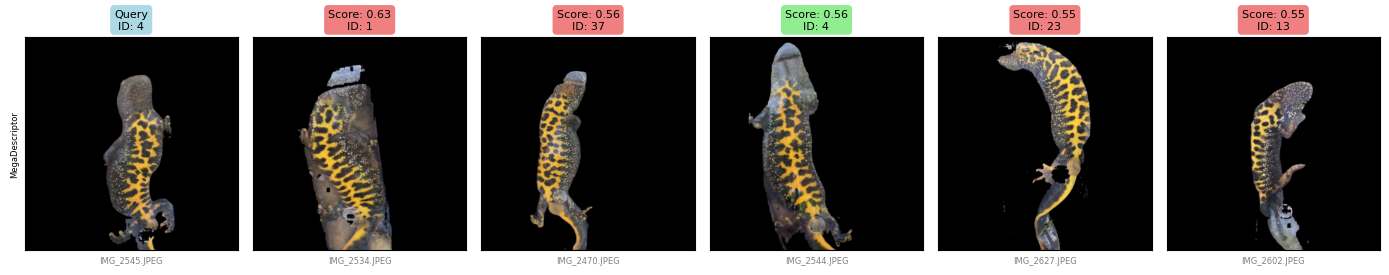

In [34]:
# Get image paths and plot first example
row = acc_mega_top_5_hard_df.iloc[0]
plt.figure(figsize=(14, 14))

plot_predictions(query_id=row['query', 'identity'], 
                query_image_name=row['query', 'image_name'], 
                pred_scores=row['score'],
                pred_image_ids=row['predicted_identity'], 
                pred_image_names=row['predicted_image_name'], 
                master_df=df,
                data_path=dataset_path,
                query_transforms=mega_transform,
                pred_transforms=mega_transform,
                denorm_mean=0.5,
                denorm_std=0.5,
                masked=True,
                model_name=mega)

# plt.savefig(results_preview_path/'prediction_example.svg', format='svg', dpi=300, bbox_inches='tight')
# plt.close()



In [35]:
dict_of_pred_transforms = {
    f'{mega}/{original}': mega_transform,
    f'{miewid}/{original}': miewid_transform,
    f'{mega}/{bg_removed}': mega_transform,
    f'{miewid}/{bg_removed}': miewid_transform,
    f'{mega}/{rotated}': mega_transform_rotated,
    f'{miewid}/{rotated}': miewid_transform_rotated,
    f'{mega}/{bg_removed_rotated}': mega_transform_rotated,
    f'{miewid}/{bg_removed_rotated}': miewid_transform_rotated,
}

save_path = artifacts_path/'results_preview'
save_path.mkdir(exist_ok=True)

for i, row in tqdm(all_results_df[:0].iterrows(), total=len(all_results_df)):
    key = f'{row.model.iloc[0]}/{row.debiasing.iloc[0]}'
    pred_transforms = dict_of_pred_transforms[key]
    query_transforms = mega_transform if row.model.iloc[0] == mega else miewid_transform

    if row.model.iloc[0] == mega:
        denorm_mean = 0.5
        denorm_std = 0.5
    else:
        denorm_mean = [0.485, 0.456, 0.406] 
        denorm_std = [0.229, 0.224, 0.225] 

    masked = row.debiasing.iloc[0] == bg_removed or row.debiasing.iloc[0] == bg_removed_rotated

    plt.figure(figsize=(10, 10))
    plot_predictions(query_id=row['query', 'identity'], 
                query_image_name=row['query', 'image_name'], 
                pred_scores=row['score'],
                pred_image_ids=row['predicted_identity'], 
                pred_image_names=row['predicted_image_name'], 
                master_df=df,
                data_path=dataset_path,
                query_transforms=query_transforms,
                pred_transforms=pred_transforms,
                denorm_mean=denorm_mean,
                denorm_std=denorm_std,
                masked=masked,
                model_name=row.model.iloc[0])

    file_name = f'query_id_{row["query", "identity"]}_{row["query", "image_name"]}_{row.model.iloc[0]}_{row.debiasing.iloc[0]}_split_{row.split.iloc[0]}.pdf'
    plt.savefig(save_path/file_name, format='pdf', dpi=300, bbox_inches='tight')
    plt.close()

  0%|          | 0/720 [00:00<?, ?it/s]
